In [3]:
import numpy as np
import matplotlib.pyplot as plt

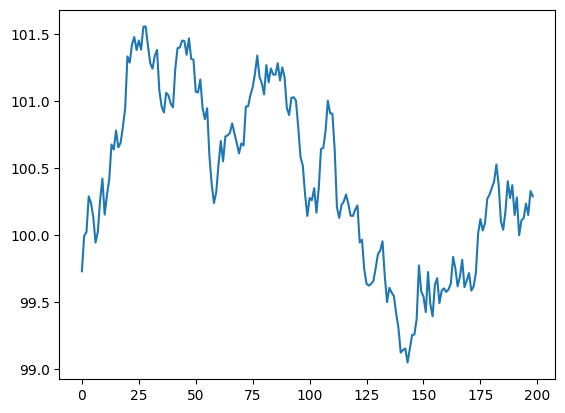

In [30]:
# Sample M paths of length T with N steps from a scaled brownian motion with 0 drift and variance sigma^2
def Sample_Brownian(S0,sigma,N,T,M):
    dt = T/N
    # np.random.normal takes stdev as parameter, hence sqrt(dt)
    St = sigma*np.random.normal(0,np.sqrt(dt), (M,N-1)).T
    St = S0+St.cumsum(axis=0)
    return St

plt.plot(Sample_Brownian(100,2,int(1/0.005),1,1))
plt.show()

In [31]:
def computeReservePrice(s,q,gamma,sigma,t,T):
    return s-q*gamma*(sigma**2)*(T-t)

def computeSpread(gamma,sigma,t,T,k):
    return (gamma*(sigma**2)*(T-t))+((2/gamma)*np.log(1+(gamma/k)))
    spread = gamma * sigma**2 * (T - step * dt) + (2 / gamma) * np.log(1 + (gamma / k))

def computeRate(A,k,delta):
    return A*np.exp(-k*delta)

def computeSamplePath(S0, sigma, dt, T):
    return np.insert(S0 + np.cumsum(sigma*np.sqrt(dt)*np.random.choice([1,-1], int(T/dt))), 0, S0)

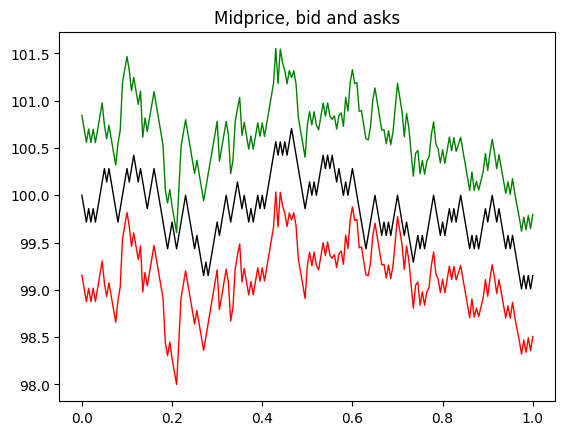

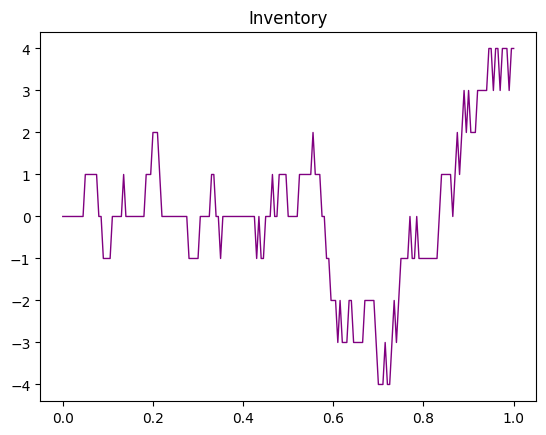

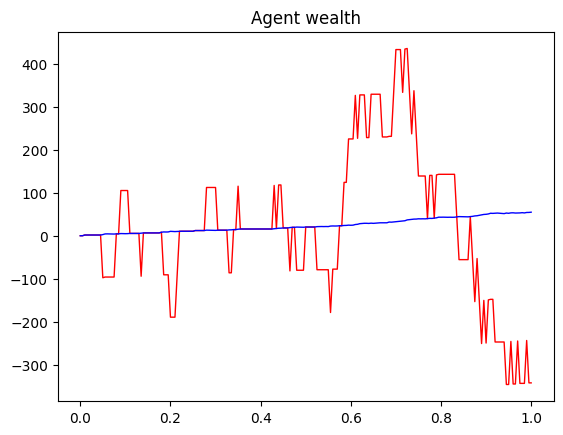

In [60]:
def simulateInventoryStrategy(plots=False):
    # initial stock price
    S0=100
    # end time
    T=1
    # std dev of stock
    sigma=2
    # time step
    dt=0.005
    # initial inventory
    q=0
    # risk-aversion parameter
    gamma=0.1
    # 
    k=1.5
    # 
    A=140
    # initial wealth
    X=0
    
    bids = []
    asks = []
    wealth = []
    adj_wealth = []
    inventory = []

    price_process = computeSamplePath(S0, sigma, dt, T)

    for step, s in enumerate(price_process):
        # set bid/ask
        r = computeReservePrice(s,q,gamma,sigma,step*dt,T)
        spread = computeSpread(gamma,sigma,step*dt,T,k)/2
        delta_a = (spread+r)-s
        delta_b = s-(r-spread)

        asks.append(s+delta_a)
        bids.append(s-delta_b)
        wealth.append(X)
        adj_wealth.append(X+q*price_process[step])
        inventory.append(q)

        # sample market orders
        prob_a = min(computeRate(A,k,delta_a)*dt, 1)
        prob_b = min(computeRate(A,k,delta_b)*dt, 1)
        p = np.random.default_rng().uniform(0,1,None)
        if p <= prob_a:
            q -= 1
            X += (s+delta_a)
        p = np.random.default_rng().uniform(0,1,None)
        if p <= prob_b:
            q += 1
            X -= (s-delta_b)

    if(plots):
        t = np.arange(0, T+dt, dt)
        plt.plot(t, price_process, 'black', linewidth=1.0)
        plt.plot(t, asks, 'green', linewidth=1.0)
        plt.plot(t, bids, 'red',linewidth=1.0)
        plt.title("Midprice, bid and asks")
        plt.show()
        plt.plot(t, inventory, 'purple', linewidth=1.0)
        plt.title("Inventory")
        plt.show()
        plt.title("Agent wealth")
        plt.plot(t, wealth, "red", linewidth=1.0)
        plt.plot(t, adj_wealth, "blue", linewidth=1.0)
        plt.show()
        
    return((wealth[step-1],inventory[step-1],s))

results = simulateInventoryStrategy(plots=True)

In [61]:
series = []
for i in range(1000):
    series.append(simulateInventoryStrategy())

64.42376147680044
6.558993200829154
42.17273110394069
86.27253711567681


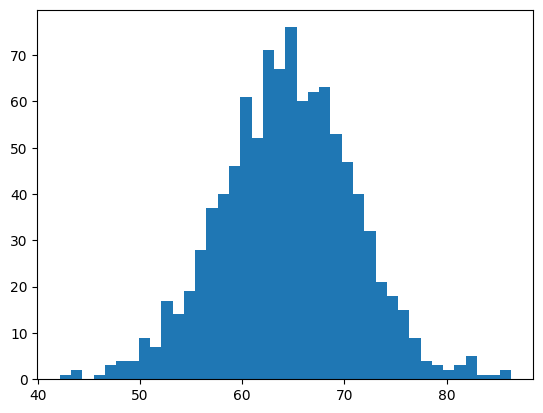

-0.04
2.828497834540447


In [62]:
series = np.array(series)
final_inv = series[:,1]
adj_wealth = series[:,0]+final_inv*series[:,2]
print(np.mean(adj_wealth))
print(np.std(adj_wealth))
print(np.min(adj_wealth))
print(np.max(adj_wealth))
plt.hist(adj_wealth,bins=40)
plt.show()
print(np.mean(final_inv))
print(np.std(final_inv))

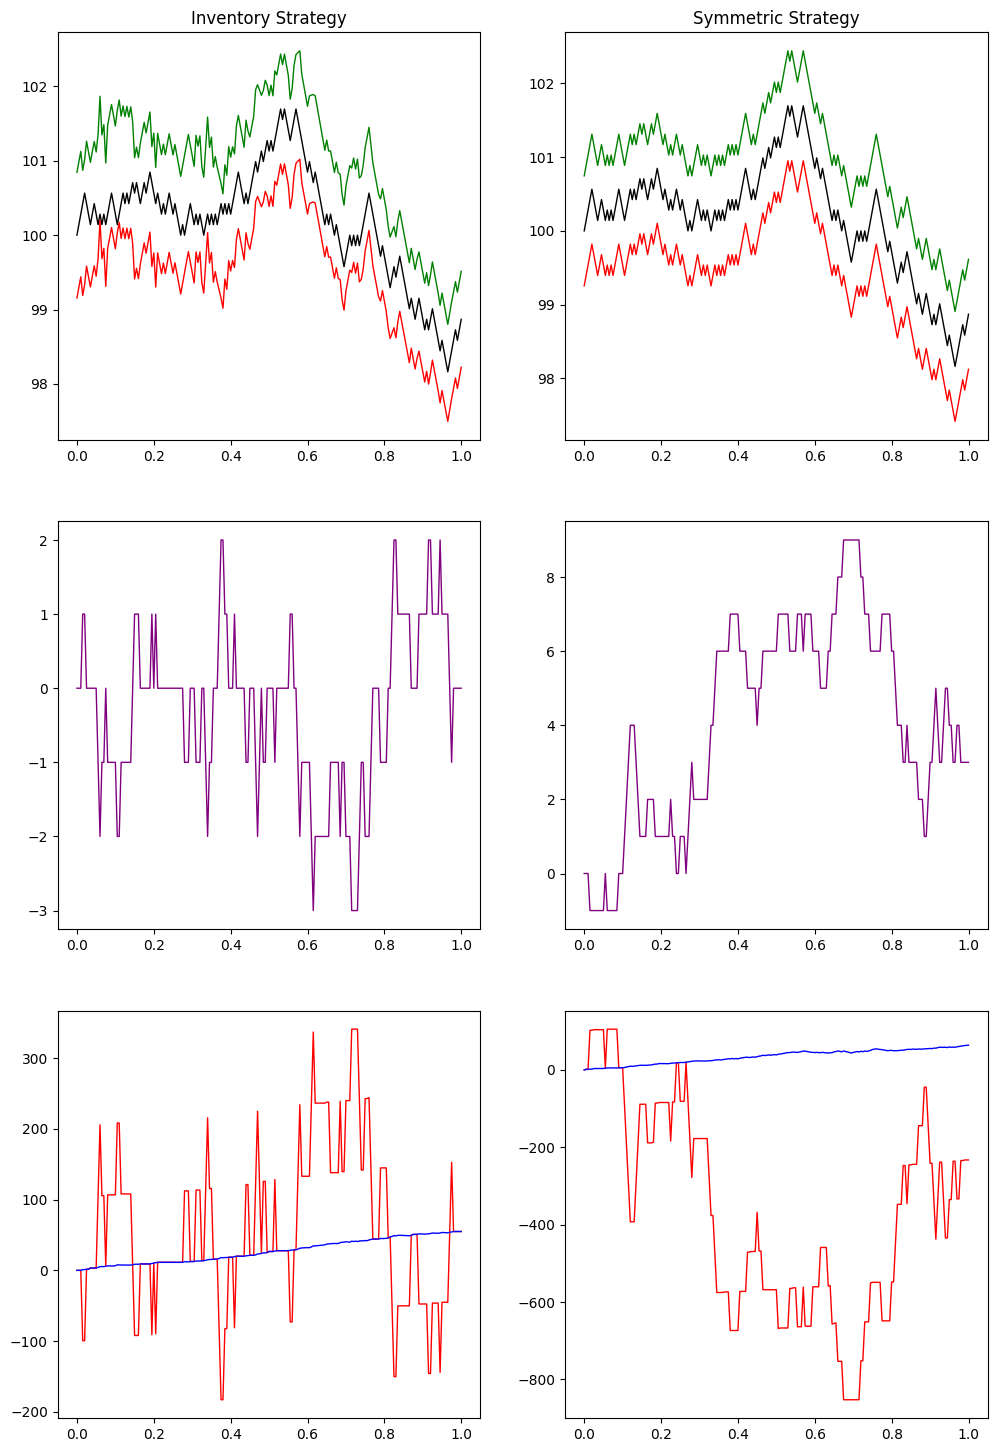

In [81]:
def simulateBothStrategies(plots=False):
    # initial stock price
    S0=100
    # end time
    T=1
    # std dev of stock
    sigma=2
    # time step
    dt=0.005
    # initial inventory
    inv_q=0
    sym_q=0
    # risk-aversion parameter
    gamma=0.1
    # 
    k=1.5
    # 
    A=140
    # initial wealth
    inv_X=0
    sym_X=0

    inv_bids = []
    inv_asks = []
    inv_wealth = []
    inv_adj_wealth = []
    inv_inventory = []

    sym_bids=[]
    sym_asks=[]
    sym_wealth = []
    sym_adj_wealth = []
    sym_inventory = []

    price_process = computeSamplePath(S0, sigma, dt, T)
    
    sym_spread = 0
    for i in np.arange(0, T, dt):
        sym_spread += computeSpread(gamma, sigma, i, T, k)
    av_sym_spread = (sym_spread / (T / dt))
    sym_prob = min(A * np.exp(- k * av_sym_spread / 2) * dt, 1)
    sym_bids = price_process - av_sym_spread/2
    sym_asks = price_process + av_sym_spread/2

    for step, s in enumerate(price_process):
        # set bid/ask
        r = computeReservePrice(s,inv_q,gamma,sigma,step*dt,T)
        spread = computeSpread(gamma,sigma,step*dt,T,k)/2
        delta_a = (spread+r)-s
        delta_b = s-(r-spread)

        inv_asks.append(s+delta_a)
        inv_bids.append(s-delta_b)
        inv_wealth.append(inv_X)
        inv_adj_wealth.append(inv_X+inv_q*s)
        inv_inventory.append(inv_q)

        # sample market orders
        prob_a = min(computeRate(A,k,delta_a)*dt, 1)
        prob_b = min(computeRate(A,k,delta_b)*dt, 1)
        p = np.random.default_rng().uniform(0,1,None)
        if p <= prob_a:
            inv_q -= 1
            inv_X += (s+delta_a)
        p = np.random.default_rng().uniform(0,1,None)
        if p <= prob_b:
            inv_q += 1
            inv_X -= (s-delta_b)

        # symmetric strategy
        sym_wealth.append(sym_X)
        sym_adj_wealth.append(sym_X+sym_q*s)
        sym_inventory.append(sym_q)

        p = np.random.default_rng().uniform(0,1,None)
        if p <= sym_prob:
            sym_q -= 1
            sym_X += (s+av_sym_spread/2)
        p = np.random.default_rng().uniform(0,1,None)
        if p <= sym_prob:
            sym_q += 1
            sym_X -= (s-av_sym_spread/2)
    
    if(plots):
        t = np.arange(0, T+dt, dt)
        fig, axs = plt.subplots(3,2, figsize=(12,18))
        axs[0,0].plot(t, price_process, 'black', linewidth=1.0)
        axs[0,0].plot(t, inv_asks, 'green', linewidth=1.0)
        axs[0,0].plot(t, inv_bids, 'red', linewidth=1.0)
        axs[0,0].set_title("Inventory Strategy")
        axs[1,0].plot(t, inv_inventory, 'purple', linewidth=1.0)
        #axs[1,0].set_title("Inventory Strategy Inventory")
        axs[2,0].plot(t, inv_wealth, "red", linewidth=1.0)
        axs[2,0].plot(t, inv_adj_wealth, "blue", linewidth=1.0)
        #axs[2,0].set_title("Inventory Strategy wealth")
        axs[0,1].plot(t, price_process, 'black', linewidth=1.0)
        axs[0,1].plot(t, sym_asks, 'green', linewidth=1.0)
        axs[0,1].plot(t, sym_bids, 'red', linewidth=1.0)
        axs[0,1].set_title("Symmetric Strategy")
        axs[1,1].plot(t, sym_inventory, 'purple', linewidth=1.0)
        #axs[1,1].set_title("Symmetric Strategy Inventory")
        axs[2,1].plot(t, sym_wealth, "red", linewidth=1.0)
        axs[2,1].plot(t, sym_adj_wealth, "blue", linewidth=1.0)
        #axs[2,1].set_title("Symmetric Strategy Wealth")
    return((inv_wealth[-1],inv_inventory[-1],price_process[-1],sym_wealth[-1],sym_inventory[-1]))

results = simulateBothStrategies(plots=True)

In [73]:
series = []
for i in range(10000):
    series.append(simulateBothStrategies())

64.89952711406958
6.5407620642716475
0.0128
2.922710413297903
68.07728237309136
13.379488826563922
0.0092
8.458576438148443


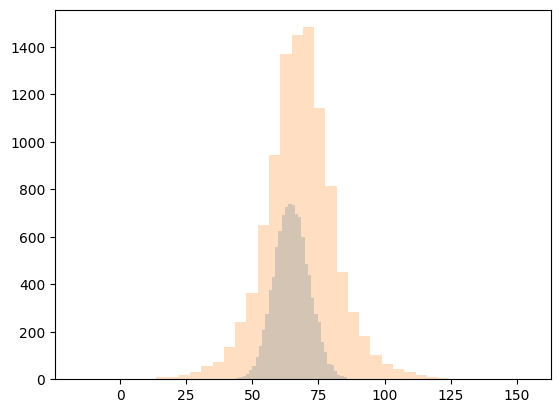

In [80]:
series = np.array(series)
inv_final_inv = series[:,1]
inv_adj_wealth = series[:,0]+inv_final_inv*series[:,2]
print(np.mean(inv_adj_wealth))
print(np.std(inv_adj_wealth))
print(np.mean(inv_final_inv))
print(np.std(inv_final_inv))

sym_final_inv = series[:,4]
sym_adj_wealth = series[:,3]+sym_final_inv*series[:,2]
print(np.mean(sym_adj_wealth))
print(np.std(sym_adj_wealth))
print(np.mean(sym_final_inv))
print(np.std(sym_final_inv))

plt.hist(inv_adj_wealth,bins=40, alpha=0.25)
plt.hist(sym_adj_wealth,bins=40, alpha=0.25)
plt.show()